In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from tqdm.notebook import tqdm, trange
from sk_models import setup_pls_models_slim, StandardScaler, PLSRegression

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [2]:
#setup input and output formats, load data

file_name = "A_C_OF_SIWARE.csv"
id_cols =[]#["sample_id"]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
model_path = Path('D:/workspace/lazydeep/experiments/1.01/')
log_path = Path("D:/workspace/lazydeep/experiments/1.05")
n_components = 63

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)


D:\workspace\lazydeep\experiments\1.05\A_C_OF_SIWARE


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)

n_features = ncol - 1-len(id_cols)
dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)
print(data.shape)

(13916, 247)


In [4]:
n_models = 100
model_names = [f"random_{i}" for i in range(0,n_models)]
deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}
#for each model, load state
print(f"Loaded {len(deep_models)} models")
#print(deep_models)
for name in model_names:
    sub_path = log_dir / name
    if not sub_path.exists():
        sub_path.mkdir()

Loaded 100 models


In [5]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")

In [6]:
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = PLSRegression(n_components=n_components)
eval = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))

In [7]:
deep_scheme = DeepScheme(None, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=True,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})
    


all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Tested (test) on 2320 instances with mean losses of: random_0:173.7125,random_1:165.1398,random_2:117.45,random_3:106.0764,random_4:124.9805,random_5:126.037,random_6:118.5291,random_7:121.4108,random_8:126.8893,random_9:140.3154,random_10:120.2772,random_11:128.632,random_12:164.4252,random_13:133.3161,random_14:114.3982,random_15:124.4254,random_16:196.1024,random_17:161.4823,random_18:113.1342,random_19:135.0113,random_20:109.8883,random_21:317.3733,random_22:134.3421,random_23:241.6692,random_24:106.1707,random_25:104.9887,random_26:127.5515,random_27:130.8678,random_28:205.3853,random_29:153.6993,random_30:217.148,random_31:187.3168,random_32:221.4989,random_33:152.2349,random_34:343.5969,random_35:119.6449,random_36:161.4446,random_37:105.309,random_38:165.6674,random_39:103.303,random_40:109.138,random_41:670.9765,random_42:128.

In [8]:
scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')

for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_60 - deep - 115.49591637973128 - 147.70492251035517 - 91.23585914259792 - 92.35466049806267 - 85.18894709940355 - 106.39684576148638 - 0.6937172342672797
1 - random_54 - deep - 122.67828775603196 - 141.09928568337898 - 95.2822361691546 - 84.50372972443166 - 97.66279256277015 - 108.24650952239685 - 0.6883926390848507
2 - random_83 - deep - 112.60841353843952 - 145.18868143427932 - 112.28975962728917 - 98.95855506692996 - 104.6625034616856 - 114.7413996438966 - 0.669695910856624
3 - random_11 - deep - 128.6319887884732 - 154.07143070143633 - 101.93082692490512 - 90.12416169765747 - 116.12413431540189 - 118.17740749700282 - 0.6598047342827631
4 - random_69 - deep - 105.78770186325599 - 155.21988306543136 - 112.0024343822063 - 101.79959000837911 - 116.74917532463122 - 118.31067885912228 - 0.6594210883100767
5 - random_5 - deep - 126.03696396926354 - 143.111247448841 - 111.72653537929547 - 102.51857789645373 - 113.2364223393041 - 119.32652774906697 - 0.656496781622675
6 - random_

In [9]:
for deep_name,deep_model in tqdm(deep_models.items()):
        logging.getLogger().info(f"Running model {deep_name}")
        temp_dict = {deep_name:deep_model}

        lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_slim(nrow,kernal=True),n_neighbours=500,loss_fun_sk = mean_squared_error)
        lwr_scores, lwr_preds, _ , _, _,_= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
        lwr_scores_final, lwr_preds_final, _ , _, _,_= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

        #scores
        for k,v in ut.flip_dicts(lwr_scores).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores.append({**dict1,**v})

        for k,v in ut.flip_dicts(lwr_scores_final).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores_final.append({**dict1,**v})

        lwr_preds['deep'] = deep_preds[deep_name]
        lwr_preds_final['deep'] = deep_preds_final[deep_name]

        lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
        lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

        #preds
        # todo save predictions - appending solns
        plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)

  0%|          | 0/100 [00:00<?, ?it/s]

Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:48.7856,lwr_k=200:76.6793,lwr_k=300:90.7711,lwr_k=400:95.5119,lwr_k=500:99.7895,lwr_k=600:102.7974,lwr_k=700:104.9276,lwr_k=800:107.087,lwr_k=900:108.6229,lwr_k=1000:110.6536'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:290.9611,lwr_k=200:174.8763,lwr_k=300:123.4346,lwr_k=400:117.119,lwr_k=500:118.6586,lwr_k=600:122.5327,lwr_k=700:118.4797,lwr_k=800:116.0429,lwr_k=900:116.1993,lwr_k=1000:117.0096'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:66.7419,lwr_k=200:86.7079,lwr_k=300:90.1292,lwr_k=400:103.2727,lwr_k=500:104.8479,lwr_k=600:106.1255,lwr_k=700:153.0305,lwr_k=800:109.4459,lwr_k=900:103.529,lwr_k=1000:106.514

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_1'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:103.2731,lwr_k=200:112.8284,lwr_k=300:117.786,lwr_k=400:120.865,lwr_k=500:123.0109,lwr_k=600:124.4096,lwr_k=700:125.8204,lwr_k=800:127.0741,lwr_k=900:128.3667,lwr_k=1000:129.2523'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:209.8304,lwr_k=200:168.4297,lwr_k=300:154.4334,lwr_k=400:139.0022,lwr_k=500:137.3535,lwr_k=600:138.4413,lwr_k=700:137.1722,lwr_k=800:136.8404,lwr_k=900:136.2962,lwr_k=1000:136.915'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:75.0447,lwr_k=200:84.3575,lwr_k=300:86.5827,lwr_k=400:89.3429,lwr_k=500:90.127,lwr_k=600:90.8033,lwr_k=700:91.2646,lwr_k=800:91.5054,lwr_k=900:92.0928,lwr_k=1000:92.4672'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_2'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:24.1998,lwr_k=200:52.6374,lwr_k=300:62.9934,lwr_k=400:70.4378,lwr_k=500:74.2041,lwr_k=600:76.6587,lwr_k=700:78.4264,lwr_k=800:79.8566,lwr_k=900:81.063,lwr_k=1000:82.1335'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:229.6508,lwr_k=200:135.9093,lwr_k=300:129.4083,lwr_k=400:122.3167,lwr_k=500:117.244,lwr_k=600:117.2863,lwr_k=700:118.6504,lwr_k=800:119.1933,lwr_k=900:116.7841,lwr_k=1000:114.9159'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:28.4596,lwr_k=200:46.7983,lwr_k=300:54.7197,lwr_k=400:59.5997,lwr_k=500:62.2302,lwr_k=600:64.7674,lwr_k=700:66.6877,lwr_k=800:68.1601,lwr_k=900:69.2408,lwr_k=1000:70.3927'
Tested (

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_3'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:95.0726,lwr_k=200:96.4273,lwr_k=300:96.665,lwr_k=400:96.6669,lwr_k=500:96.7438,lwr_k=600:96.8959,lwr_k=700:96.803,lwr_k=800:96.7417,lwr_k=900:96.7184,lwr_k=1000:96.6483'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:110.2667,lwr_k=200:110.409,lwr_k=300:110.4156,lwr_k=400:110.5262,lwr_k=500:110.9481,lwr_k=600:110.9763,lwr_k=700:111.2206,lwr_k=800:111.1731,lwr_k=900:111.3411,lwr_k=1000:111.3861'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:73.9577,lwr_k=200:75.6547,lwr_k=300:76.2039,lwr_k=400:76.4375,lwr_k=500:76.61,lwr_k=600:76.8505,lwr_k=700:76.8781,lwr_k=800:76.8875,lwr_k=900:76.9188,lwr_k=1000:76.9917'
Tested (tes

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:38.7735,lwr_k=200:65.1439,lwr_k=300:76.0517,lwr_k=400:80.1462,lwr_k=500:83.4882,lwr_k=600:85.2302,lwr_k=700:86.5474,lwr_k=800:87.7565,lwr_k=900:88.4778,lwr_k=1000:89.1878'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:179.6835,lwr_k=200:123.2678,lwr_k=300:118.7007,lwr_k=400:112.7386,lwr_k=500:113.4492,lwr_k=600:112.6619,lwr_k=700:112.0571,lwr_k=800:111.3216,lwr_k=900:110.9339,lwr_k=1000:111.291'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:31.5906,lwr_k=200:51.3232,lwr_k=300:57.0467,lwr_k=400:60.5135,lwr_k=500:63.0449,lwr_k=600:64.5167,lwr_k=700:65.7718,lwr_k=800:66.5841,lwr_k=900:67.297,lwr_k=1000:68.0905'
Tested (

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_5'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:119.7579,lwr_k=200:106.2456,lwr_k=300:99.2136,lwr_k=400:106.3114,lwr_k=500:102.4508,lwr_k=600:99.8728,lwr_k=700:97.2957,lwr_k=800:92.967,lwr_k=900:91.7791,lwr_k=1000:90.9847'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:212.7505,lwr_k=200:203.3905,lwr_k=300:183.9659,lwr_k=400:176.1099,lwr_k=500:160.6723,lwr_k=600:150.5808,lwr_k=700:144.2554,lwr_k=800:138.6327,lwr_k=900:137.1334,lwr_k=1000:134.7877'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:65.0708,lwr_k=200:72.1562,lwr_k=300:71.7407,lwr_k=400:69.7695,lwr_k=500:71.0435,lwr_k=600:68.7596,lwr_k=700:69.2446,lwr_k=800:67.8039,lwr_k=900:66.781,lwr_k=1000:66.2368'
Test

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_6'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:60.1864,lwr_k=200:54.0746,lwr_k=300:51.791,lwr_k=400:49.5202,lwr_k=500:50.706,lwr_k=600:50.8858,lwr_k=700:51.5324,lwr_k=800:51.7686,lwr_k=900:51.9275,lwr_k=1000:52.3813'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:206.934,lwr_k=200:124.3092,lwr_k=300:127.491,lwr_k=400:114.2716,lwr_k=500:126.3507,lwr_k=600:126.8505,lwr_k=700:126.4095,lwr_k=800:127.689,lwr_k=900:126.1811,lwr_k=1000:120.9839'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:75.3931,lwr_k=200:68.4945,lwr_k=300:67.7722,lwr_k=400:71.5786,lwr_k=500:68.2588,lwr_k=600:69.3925,lwr_k=700:70.5838,lwr_k=800:69.7659,lwr_k=900:71.9793,lwr_k=1000:71.3109'
Tested (tes

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_7'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:107.1174,lwr_k=200:102.5699,lwr_k=300:99.4215,lwr_k=400:100.9232,lwr_k=500:100.7773,lwr_k=600:101.1828,lwr_k=700:102.6264,lwr_k=800:102.9449,lwr_k=900:103.2256,lwr_k=1000:102.9161'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:153.273,lwr_k=200:139.7113,lwr_k=300:135.7184,lwr_k=400:132.4846,lwr_k=500:130.6807,lwr_k=600:130.7687,lwr_k=700:130.3955,lwr_k=800:129.0104,lwr_k=900:129.1238,lwr_k=1000:129.8867'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:64.352,lwr_k=200:68.254,lwr_k=300:70.9961,lwr_k=400:71.422,lwr_k=500:71.3036,lwr_k=600:71.8598,lwr_k=700:72.1138,lwr_k=800:72.5723,lwr_k=900:72.9119,lwr_k=1000:72.965'
Te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_8'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:30.6642,lwr_k=200:59.4204,lwr_k=300:69.9401,lwr_k=400:75.6793,lwr_k=500:77.9699,lwr_k=600:80.6778,lwr_k=700:81.8871,lwr_k=800:83.2021,lwr_k=900:84.2891,lwr_k=1000:85.073'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:221.353,lwr_k=200:116.6767,lwr_k=300:108.4018,lwr_k=400:101.4651,lwr_k=500:100.6372,lwr_k=600:101.1746,lwr_k=700:98.4399,lwr_k=800:96.5027,lwr_k=900:96.1411,lwr_k=1000:96.8672'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:35.1164,lwr_k=200:51.8375,lwr_k=300:59.2453,lwr_k=400:64.0866,lwr_k=500:66.7426,lwr_k=600:69.4149,lwr_k=700:71.0379,lwr_k=800:72.5658,lwr_k=900:73.4449,lwr_k=1000:74.5912'
Tested (test

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_9'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:113.2897,lwr_k=200:110.1074,lwr_k=300:107.3034,lwr_k=400:109.946,lwr_k=500:111.6013,lwr_k=600:117.0143,lwr_k=700:112.5295,lwr_k=800:112.8969,lwr_k=900:113.8135,lwr_k=1000:113.9819'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:354.0716,lwr_k=200:162.7959,lwr_k=300:164.127,lwr_k=400:155.772,lwr_k=500:148.2583,lwr_k=600:139.7086,lwr_k=700:137.7224,lwr_k=800:138.3994,lwr_k=900:138.1463,lwr_k=1000:137.1802'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:36.068,lwr_k=200:62.728,lwr_k=300:72.8081,lwr_k=400:77.2333,lwr_k=500:80.8283,lwr_k=600:84.4814,lwr_k=700:86.5711,lwr_k=800:88.6321,lwr_k=900:90.6594,lwr_k=1000:91.8878'
T

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_10'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:108.037,lwr_k=200:116.1676,lwr_k=300:118.4249,lwr_k=400:119.7811,lwr_k=500:120.53,lwr_k=600:121.3336,lwr_k=700:121.8089,lwr_k=800:122.2298,lwr_k=900:122.3843,lwr_k=1000:122.5395'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:154.2699,lwr_k=200:121.4014,lwr_k=300:124.8659,lwr_k=400:125.9203,lwr_k=500:121.3876,lwr_k=600:120.2796,lwr_k=700:119.3066,lwr_k=800:120.0596,lwr_k=900:119.8925,lwr_k=1000:119.447'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:85.7243,lwr_k=200:94.2936,lwr_k=300:97.2564,lwr_k=400:99.0707,lwr_k=500:100.399,lwr_k=600:101.2613,lwr_k=700:102.2741,lwr_k=800:102.7321,lwr_k=900:103.263,lwr_k=1000:103.6

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_11'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:86.1557,lwr_k=200:75.8729,lwr_k=300:80.8139,lwr_k=400:78.4847,lwr_k=500:80.5575,lwr_k=600:81.5443,lwr_k=700:80.0936,lwr_k=800:80.8774,lwr_k=900:80.0973,lwr_k=1000:79.8614'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:234.1077,lwr_k=200:138.2959,lwr_k=300:136.5831,lwr_k=400:159.7959,lwr_k=500:134.896,lwr_k=600:141.2945,lwr_k=700:143.3408,lwr_k=800:138.6858,lwr_k=900:131.039,lwr_k=1000:130.3498'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:55.6413,lwr_k=200:56.9447,lwr_k=300:59.9851,lwr_k=400:60.4997,lwr_k=500:60.8225,lwr_k=600:58.8878,lwr_k=700:59.9589,lwr_k=800:58.9787,lwr_k=900:58.8268,lwr_k=1000:59.4062'
Tested 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_12'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:124.7857,lwr_k=200:126.2528,lwr_k=300:125.8697,lwr_k=400:125.3427,lwr_k=500:124.8775,lwr_k=600:125.0134,lwr_k=700:124.9892,lwr_k=800:125.1625,lwr_k=900:125.3,lwr_k=1000:125.5957'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:162.5322,lwr_k=200:161.8122,lwr_k=300:161.56,lwr_k=400:160.3634,lwr_k=500:160.7724,lwr_k=600:160.6486,lwr_k=700:160.8193,lwr_k=800:160.5507,lwr_k=900:160.6744,lwr_k=1000:160.4289'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:77.576,lwr_k=200:78.8053,lwr_k=300:80.117,lwr_k=400:80.0959,lwr_k=500:80.0791,lwr_k=600:80.069,lwr_k=700:80.0971,lwr_k=800:80.1201,lwr_k=900:80.1293,lwr_k=1000:80.1141'
Tes

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_13'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:115.0851,lwr_k=200:119.0741,lwr_k=300:121.8899,lwr_k=400:122.5084,lwr_k=500:123.4084,lwr_k=600:123.5027,lwr_k=700:124.032,lwr_k=800:124.3319,lwr_k=900:124.5422,lwr_k=1000:124.8995'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:117.2467,lwr_k=200:114.4602,lwr_k=300:117.3408,lwr_k=400:115.7577,lwr_k=500:114.5644,lwr_k=600:114.3751,lwr_k=700:114.1829,lwr_k=800:114.4162,lwr_k=900:114.3387,lwr_k=1000:114.3713'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:88.6507,lwr_k=200:92.7427,lwr_k=300:94.9609,lwr_k=400:95.8716,lwr_k=500:96.8211,lwr_k=600:97.0021,lwr_k=700:97.3771,lwr_k=800:97.7246,lwr_k=900:97.9992,lwr_k=1000:98.23

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_14'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:55.8336,lwr_k=200:77.1855,lwr_k=300:85.9404,lwr_k=400:92.6786,lwr_k=500:93.3891,lwr_k=600:96.4453,lwr_k=700:97.2856,lwr_k=800:99.2063,lwr_k=900:100.1867,lwr_k=1000:100.804'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:252.7369,lwr_k=200:181.9861,lwr_k=300:132.7387,lwr_k=400:134.4894,lwr_k=500:139.8786,lwr_k=600:126.9255,lwr_k=700:124.4261,lwr_k=800:125.0479,lwr_k=900:128.2741,lwr_k=1000:118.4246'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:82.9123,lwr_k=200:87.1956,lwr_k=300:87.9532,lwr_k=400:88.7079,lwr_k=500:89.7533,lwr_k=600:90.8627,lwr_k=700:90.7669,lwr_k=800:91.2715,lwr_k=900:91.751,lwr_k=1000:91.5841'
Teste

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_15'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:67.8728,lwr_k=200:84.061,lwr_k=300:90.067,lwr_k=400:93.667,lwr_k=500:95.5041,lwr_k=600:96.4347,lwr_k=700:97.2808,lwr_k=800:97.8176,lwr_k=900:98.2845,lwr_k=1000:98.4978'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:144.1839,lwr_k=200:122.6331,lwr_k=300:113.6304,lwr_k=400:107.8805,lwr_k=500:107.0909,lwr_k=600:106.4724,lwr_k=700:106.4603,lwr_k=800:106.1253,lwr_k=900:106.1217,lwr_k=1000:106.3242'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:53.979,lwr_k=200:66.394,lwr_k=300:72.1144,lwr_k=400:75.7232,lwr_k=500:77.2417,lwr_k=600:78.9165,lwr_k=700:79.8661,lwr_k=800:80.6811,lwr_k=900:81.1942,lwr_k=1000:81.765'
Tested (tes

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_16'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:47.3219,lwr_k=200:76.6067,lwr_k=300:84.3844,lwr_k=400:90.2071,lwr_k=500:93.5464,lwr_k=600:96.2898,lwr_k=700:98.0551,lwr_k=800:100.2668,lwr_k=900:100.334,lwr_k=1000:101.5624'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:275.8845,lwr_k=200:142.2313,lwr_k=300:126.067,lwr_k=400:117.4647,lwr_k=500:116.3526,lwr_k=600:114.9669,lwr_k=700:114.6215,lwr_k=800:114.1653,lwr_k=900:114.2761,lwr_k=1000:113.8566'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:28.3458,lwr_k=200:46.3878,lwr_k=300:52.5078,lwr_k=400:56.0604,lwr_k=500:58.0033,lwr_k=600:59.6473,lwr_k=700:61.102,lwr_k=800:62.0829,lwr_k=900:63.1139,lwr_k=1000:63.9184'
Teste

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_17'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:90.1627,lwr_k=200:101.2965,lwr_k=300:107.0622,lwr_k=400:108.9708,lwr_k=500:109.3625,lwr_k=600:113.5712,lwr_k=700:112.8317,lwr_k=800:115.2944,lwr_k=900:117.6142,lwr_k=1000:119.8248'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:144.6643,lwr_k=200:128.2243,lwr_k=300:124.3199,lwr_k=400:138.8109,lwr_k=500:149.0712,lwr_k=600:144.4222,lwr_k=700:136.8805,lwr_k=800:134.1354,lwr_k=900:138.1249,lwr_k=1000:127.1879'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:200.5148,lwr_k=200:202.4654,lwr_k=300:203.0882,lwr_k=400:203.2456,lwr_k=500:203.4918,lwr_k=600:204.897,lwr_k=700:206.625,lwr_k=800:209.587,lwr_k=900:211.9076,lwr_k=1000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_18'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:93.0389,lwr_k=200:94.4385,lwr_k=300:95.5289,lwr_k=400:95.8306,lwr_k=500:96.7235,lwr_k=600:97.0227,lwr_k=700:96.9186,lwr_k=800:96.7154,lwr_k=900:96.9365,lwr_k=1000:96.752'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:135.7385,lwr_k=200:131.3822,lwr_k=300:123.252,lwr_k=400:122.1239,lwr_k=500:119.5546,lwr_k=600:117.5762,lwr_k=700:117.8524,lwr_k=800:118.3181,lwr_k=900:117.6995,lwr_k=1000:116.9222'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:76.3617,lwr_k=200:81.5832,lwr_k=300:84.8271,lwr_k=400:85.6755,lwr_k=500:86.2902,lwr_k=600:87.1575,lwr_k=700:87.5478,lwr_k=800:87.8433,lwr_k=900:87.9211,lwr_k=1000:88.1136'
Tested 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_19'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:109.4578,lwr_k=200:114.9032,lwr_k=300:117.9943,lwr_k=400:119.2614,lwr_k=500:120.2247,lwr_k=600:120.8646,lwr_k=700:121.4218,lwr_k=800:122.1581,lwr_k=900:122.7166,lwr_k=1000:123.0441'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:123.9509,lwr_k=200:121.2455,lwr_k=300:120.783,lwr_k=400:120.7168,lwr_k=500:122.1486,lwr_k=600:121.3391,lwr_k=700:121.5284,lwr_k=800:121.4019,lwr_k=900:121.3907,lwr_k=1000:121.4625'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:88.7862,lwr_k=200:96.8512,lwr_k=300:99.4658,lwr_k=400:102.7613,lwr_k=500:104.5505,lwr_k=600:105.8556,lwr_k=700:106.2953,lwr_k=800:106.9278,lwr_k=900:107.8385,lwr_k=1000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_20'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:95.312,lwr_k=200:99.9266,lwr_k=300:101.5881,lwr_k=400:99.4641,lwr_k=500:98.9752,lwr_k=600:98.3676,lwr_k=700:98.0366,lwr_k=800:99.3063,lwr_k=900:100.488,lwr_k=1000:100.6554'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:108.054,lwr_k=200:112.2196,lwr_k=300:110.4827,lwr_k=400:103.8687,lwr_k=500:115.7084,lwr_k=600:113.9143,lwr_k=700:108.6797,lwr_k=800:111.5543,lwr_k=900:108.2434,lwr_k=1000:108.4326'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:84.3994,lwr_k=200:85.117,lwr_k=300:84.9371,lwr_k=400:84.9049,lwr_k=500:85.8215,lwr_k=600:84.816,lwr_k=700:85.3489,lwr_k=800:86.1559,lwr_k=900:85.2189,lwr_k=1000:85.2013'
Tested 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_21'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:56.1668,lwr_k=200:89.2492,lwr_k=300:100.1276,lwr_k=400:107.9548,lwr_k=500:111.8591,lwr_k=600:115.9907,lwr_k=700:119.0816,lwr_k=800:121.6179,lwr_k=900:124.1568,lwr_k=1000:126.0129'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:230.5625,lwr_k=200:162.0796,lwr_k=300:134.0008,lwr_k=400:126.9065,lwr_k=500:122.7041,lwr_k=600:123.3962,lwr_k=700:123.3184,lwr_k=800:125.6488,lwr_k=900:129.2318,lwr_k=1000:130.3722'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:38.0299,lwr_k=200:61.4178,lwr_k=300:75.7274,lwr_k=400:84.3667,lwr_k=500:90.8705,lwr_k=600:95.2617,lwr_k=700:99.2251,lwr_k=800:102.7335,lwr_k=900:105.4348,lwr_k=1000:107.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_22'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:125.2554,lwr_k=200:126.6736,lwr_k=300:127.9857,lwr_k=400:130.1774,lwr_k=500:131.2559,lwr_k=600:131.7727,lwr_k=700:132.1403,lwr_k=800:132.3135,lwr_k=900:132.3513,lwr_k=1000:132.5519'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:130.8392,lwr_k=200:126.7854,lwr_k=300:124.2731,lwr_k=400:123.1109,lwr_k=500:122.2234,lwr_k=600:122.4286,lwr_k=700:121.958,lwr_k=800:121.4996,lwr_k=900:121.7813,lwr_k=1000:121.9429'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:322.5987,lwr_k=200:322.6803,lwr_k=300:322.6163,lwr_k=400:322.7505,lwr_k=500:322.7386,lwr_k=600:322.7369,lwr_k=700:322.6015,lwr_k=800:322.6196,lwr_k=900:322.6571,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_23'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:144.7539,lwr_k=200:143.3214,lwr_k=300:143.1357,lwr_k=400:147.0007,lwr_k=500:148.7644,lwr_k=600:149.6165,lwr_k=700:150.6658,lwr_k=800:151.5209,lwr_k=900:152.2959,lwr_k=1000:153.067'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:169.6781,lwr_k=200:153.0745,lwr_k=300:164.4234,lwr_k=400:165.028,lwr_k=500:167.0986,lwr_k=600:168.3063,lwr_k=700:168.7426,lwr_k=800:169.1002,lwr_k=900:169.0973,lwr_k=1000:169.3948'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:95.4321,lwr_k=200:102.1476,lwr_k=300:104.8294,lwr_k=400:107.4791,lwr_k=500:108.8098,lwr_k=600:111.0126,lwr_k=700:111.6531,lwr_k=800:112.3576,lwr_k=900:112.9416,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_24'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:64.8004,lwr_k=200:59.7411,lwr_k=300:61.5677,lwr_k=400:61.8899,lwr_k=500:59.8238,lwr_k=600:60.225,lwr_k=700:60.2213,lwr_k=800:60.1807,lwr_k=900:59.3567,lwr_k=1000:59.7625'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:269.4543,lwr_k=200:155.7237,lwr_k=300:130.4692,lwr_k=400:122.8448,lwr_k=500:120.3277,lwr_k=600:115.683,lwr_k=700:116.0759,lwr_k=800:114.2715,lwr_k=900:111.7626,lwr_k=1000:110.9098'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:110.8911,lwr_k=200:93.8437,lwr_k=300:85.3664,lwr_k=400:85.7385,lwr_k=500:84.7831,lwr_k=600:82.4765,lwr_k=700:80.322,lwr_k=800:80.2525,lwr_k=900:84.2669,lwr_k=1000:81.7398'
Tested 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:121.4756,lwr_k=200:103.5727,lwr_k=300:100.8637,lwr_k=400:97.8034,lwr_k=500:96.3211,lwr_k=600:94.9315,lwr_k=700:95.4657,lwr_k=800:93.037,lwr_k=900:93.4107,lwr_k=1000:92.7465'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:190.0573,lwr_k=200:153.6708,lwr_k=300:139.2383,lwr_k=400:129.2281,lwr_k=500:122.2002,lwr_k=600:119.5218,lwr_k=700:115.86,lwr_k=800:116.4234,lwr_k=900:116.219,lwr_k=1000:113.6666'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:95.0169,lwr_k=200:85.2238,lwr_k=300:87.279,lwr_k=400:86.6682,lwr_k=500:86.9704,lwr_k=600:88.4079,lwr_k=700:86.4873,lwr_k=800:85.2718,lwr_k=900:89.4377,lwr_k=1000:86.9291'
Tested 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_26'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:50.2212,lwr_k=200:65.5526,lwr_k=300:70.7492,lwr_k=400:73.5188,lwr_k=500:76.5475,lwr_k=600:77.7891,lwr_k=700:79.0463,lwr_k=800:79.6227,lwr_k=900:80.5423,lwr_k=1000:81.3102'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:188.4114,lwr_k=200:142.5305,lwr_k=300:117.7264,lwr_k=400:114.5227,lwr_k=500:113.3659,lwr_k=600:112.036,lwr_k=700:109.3628,lwr_k=800:108.6273,lwr_k=900:104.3079,lwr_k=1000:103.6199'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:47.9464,lwr_k=200:58.2031,lwr_k=300:62.1797,lwr_k=400:64.811,lwr_k=500:66.8215,lwr_k=600:67.7705,lwr_k=700:69.5188,lwr_k=800:70.8627,lwr_k=900:71.8089,lwr_k=1000:72.6911'
Tested 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_27'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:101.333,lwr_k=200:109.4333,lwr_k=300:113.0349,lwr_k=400:115.0247,lwr_k=500:116.5407,lwr_k=600:117.2432,lwr_k=700:118.0592,lwr_k=800:118.5228,lwr_k=900:119.0814,lwr_k=1000:119.7175'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:119.5089,lwr_k=200:123.8652,lwr_k=300:122.8898,lwr_k=400:123.1744,lwr_k=500:123.1814,lwr_k=600:122.9415,lwr_k=700:123.553,lwr_k=800:123.6993,lwr_k=900:123.218,lwr_k=1000:122.9166'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:80.9167,lwr_k=200:92.8916,lwr_k=300:97.9297,lwr_k=400:100.0176,lwr_k=500:102.3585,lwr_k=600:103.7025,lwr_k=700:105.3327,lwr_k=800:105.8744,lwr_k=900:106.4667,lwr_k=1000:1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_28'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:119.116,lwr_k=200:118.9649,lwr_k=300:116.5325,lwr_k=400:117.9069,lwr_k=500:125.6789,lwr_k=600:124.3742,lwr_k=700:121.8154,lwr_k=800:121.7177,lwr_k=900:120.2613,lwr_k=1000:120.8803'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:133.0731,lwr_k=200:131.6961,lwr_k=300:133.8098,lwr_k=400:124.5713,lwr_k=500:142.8353,lwr_k=600:138.7349,lwr_k=700:149.5912,lwr_k=800:133.9223,lwr_k=900:133.2526,lwr_k=1000:131.9572'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:102.5333,lwr_k=200:103.9285,lwr_k=300:104.7506,lwr_k=400:103.9274,lwr_k=500:105.1529,lwr_k=600:103.925,lwr_k=700:105.7285,lwr_k=800:105.8038,lwr_k=900:104.7923,lwr_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:111.718,lwr_k=200:111.5474,lwr_k=300:111.3466,lwr_k=400:115.5749,lwr_k=500:114.706,lwr_k=600:114.9756,lwr_k=700:113.7789,lwr_k=800:109.0386,lwr_k=900:115.0296,lwr_k=1000:118.7965'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:128.809,lwr_k=200:128.5628,lwr_k=300:129.3994,lwr_k=400:135.7054,lwr_k=500:133.3635,lwr_k=600:134.4291,lwr_k=700:132.3669,lwr_k=800:123.9418,lwr_k=900:133.6285,lwr_k=1000:138.5755'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:123.7764,lwr_k=200:120.4163,lwr_k=300:120.8212,lwr_k=400:121.5805,lwr_k=500:122.4577,lwr_k=600:123.7823,lwr_k=700:122.5238,lwr_k=800:124.6611,lwr_k=900:126.9079,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_30'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:135.2744,lwr_k=200:139.4885,lwr_k=300:146.7516,lwr_k=400:150.3728,lwr_k=500:157.8851,lwr_k=600:158.1349,lwr_k=700:161.2354,lwr_k=800:163.4179,lwr_k=900:164.1677,lwr_k=1000:164.8683'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:234.9769,lwr_k=200:170.4006,lwr_k=300:168.8039,lwr_k=400:175.091,lwr_k=500:181.7351,lwr_k=600:181.4152,lwr_k=700:184.3921,lwr_k=800:188.3206,lwr_k=900:188.3665,lwr_k=1000:188.1674'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:87.7223,lwr_k=200:86.1069,lwr_k=300:83.1208,lwr_k=400:83.5352,lwr_k=500:83.6275,lwr_k=600:84.4701,lwr_k=700:84.7834,lwr_k=800:85.8493,lwr_k=900:86.1331,lwr_k=1000:86.19

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_31'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:46.4789,lwr_k=200:70.6305,lwr_k=300:84.1069,lwr_k=400:92.4517,lwr_k=500:97.3069,lwr_k=600:100.5406,lwr_k=700:103.6929,lwr_k=800:105.9643,lwr_k=900:107.5452,lwr_k=1000:109.5064'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:332.8987,lwr_k=200:142.6377,lwr_k=300:120.6611,lwr_k=400:120.6607,lwr_k=500:115.187,lwr_k=600:114.5102,lwr_k=700:115.254,lwr_k=800:115.9712,lwr_k=900:117.1698,lwr_k=1000:116.7493'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:35.7172,lwr_k=200:56.3132,lwr_k=300:66.1981,lwr_k=400:71.8616,lwr_k=500:75.5638,lwr_k=600:79.4794,lwr_k=700:82.0139,lwr_k=800:84.5797,lwr_k=900:85.7185,lwr_k=1000:87.2372'
Te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_32'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:104.3513,lwr_k=200:115.7531,lwr_k=300:120.7291,lwr_k=400:123.5357,lwr_k=500:125.1758,lwr_k=600:126.1208,lwr_k=700:127.5418,lwr_k=800:129.0334,lwr_k=900:130.1181,lwr_k=1000:131.0456'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:232.2195,lwr_k=200:180.0341,lwr_k=300:169.9712,lwr_k=400:167.7614,lwr_k=500:164.453,lwr_k=600:163.6074,lwr_k=700:163.807,lwr_k=800:164.1968,lwr_k=900:163.435,lwr_k=1000:163.6272'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:95.7412,lwr_k=200:94.5937,lwr_k=300:97.5322,lwr_k=400:99.0991,lwr_k=500:99.6214,lwr_k=600:100.3913,lwr_k=700:100.9601,lwr_k=800:100.8037,lwr_k=900:101.2461,lwr_k=1000:101

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_33'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:59.8811,lwr_k=200:79.6162,lwr_k=300:86.1407,lwr_k=400:91.2687,lwr_k=500:94.2386,lwr_k=600:96.4034,lwr_k=700:98.9885,lwr_k=800:100.9507,lwr_k=900:102.9146,lwr_k=1000:104.2518'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:227.4888,lwr_k=200:152.0238,lwr_k=300:146.5592,lwr_k=400:138.2258,lwr_k=500:122.3437,lwr_k=600:118.7837,lwr_k=700:119.5985,lwr_k=800:119.3216,lwr_k=900:123.5937,lwr_k=1000:120.045'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:50.7992,lwr_k=200:69.9639,lwr_k=300:77.4292,lwr_k=400:81.1061,lwr_k=500:84.0645,lwr_k=600:86.7999,lwr_k=700:88.5865,lwr_k=800:91.4064,lwr_k=900:92.9958,lwr_k=1000:94.383'
Test

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_34'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:339.6882,lwr_k=200:341.2668,lwr_k=300:337.8672,lwr_k=400:337.8628,lwr_k=500:337.8682,lwr_k=600:337.9922,lwr_k=700:338.3777,lwr_k=800:338.1711,lwr_k=900:338.1347,lwr_k=1000:338.1206'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:345.9773,lwr_k=200:347.7481,lwr_k=300:343.6623,lwr_k=400:343.6451,lwr_k=500:343.6658,lwr_k=600:343.8963,lwr_k=700:344.4204,lwr_k=800:344.1508,lwr_k=900:344.1014,lwr_k=1000:344.0819'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:322.6336,lwr_k=200:322.714,lwr_k=300:322.6506,lwr_k=400:322.7837,lwr_k=500:322.7719,lwr_k=600:322.7702,lwr_k=700:322.6362,lwr_k=800:322.6552,lwr_k=900:322.6931,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_35'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:105.0266,lwr_k=200:104.9444,lwr_k=300:105.1402,lwr_k=400:105.0347,lwr_k=500:105.19,lwr_k=600:105.2089,lwr_k=700:105.5231,lwr_k=800:105.5987,lwr_k=900:105.7141,lwr_k=1000:105.6975'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:121.3558,lwr_k=200:120.784,lwr_k=300:120.1288,lwr_k=400:120.2342,lwr_k=500:120.5738,lwr_k=600:120.7316,lwr_k=700:120.7387,lwr_k=800:120.7512,lwr_k=900:120.7349,lwr_k=1000:120.7782'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:81.4342,lwr_k=200:82.6429,lwr_k=300:83.5901,lwr_k=400:84.0111,lwr_k=500:84.3506,lwr_k=600:84.5004,lwr_k=700:84.584,lwr_k=800:84.661,lwr_k=900:84.7444,lwr_k=1000:84.7206'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_36'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:141.0416,lwr_k=200:141.4823,lwr_k=300:142.2865,lwr_k=400:142.4002,lwr_k=500:142.7564,lwr_k=600:142.4287,lwr_k=700:142.3687,lwr_k=800:144.3538,lwr_k=900:145.0825,lwr_k=1000:144.8246'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:147.9584,lwr_k=200:147.9857,lwr_k=300:147.8408,lwr_k=400:148.4556,lwr_k=500:148.5657,lwr_k=600:150.217,lwr_k=700:149.7757,lwr_k=800:150.6198,lwr_k=900:152.1496,lwr_k=1000:151.9514'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:122.4223,lwr_k=200:113.59,lwr_k=300:115.6842,lwr_k=400:115.6955,lwr_k=500:114.5702,lwr_k=600:116.4061,lwr_k=700:115.5867,lwr_k=800:113.0831,lwr_k=900:115.5204,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:78.8418,lwr_k=200:92.2034,lwr_k=300:98.376,lwr_k=400:100.9844,lwr_k=500:102.5998,lwr_k=600:103.5371,lwr_k=700:104.9482,lwr_k=800:105.6626,lwr_k=900:106.2299,lwr_k=1000:106.7435'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:125.6011,lwr_k=200:104.0672,lwr_k=300:104.5415,lwr_k=400:100.6461,lwr_k=500:100.2503,lwr_k=600:100.0194,lwr_k=700:100.814,lwr_k=800:100.4897,lwr_k=900:100.4201,lwr_k=1000:100.0942'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:47.2239,lwr_k=200:64.4136,lwr_k=300:74.4576,lwr_k=400:79.2322,lwr_k=500:81.8189,lwr_k=600:83.099,lwr_k=700:83.9896,lwr_k=800:84.9486,lwr_k=900:85.4467,lwr_k=1000:86.0266'
T

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_38'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:62.3594,lwr_k=200:81.2806,lwr_k=300:89.7056,lwr_k=400:95.0026,lwr_k=500:99.4555,lwr_k=600:103.5422,lwr_k=700:107.0216,lwr_k=800:110.3478,lwr_k=900:112.1442,lwr_k=1000:114.5705'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:143.7278,lwr_k=200:117.7712,lwr_k=300:116.2374,lwr_k=400:115.005,lwr_k=500:116.3165,lwr_k=600:111.6563,lwr_k=700:112.3807,lwr_k=800:111.2671,lwr_k=900:112.693,lwr_k=1000:116.0198'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:47.9668,lwr_k=200:65.6536,lwr_k=300:73.2206,lwr_k=400:79.3256,lwr_k=500:82.8456,lwr_k=600:86.2746,lwr_k=700:89.4425,lwr_k=800:91.3992,lwr_k=900:92.8245,lwr_k=1000:94.5061'
Te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_39'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:82.573,lwr_k=200:93.129,lwr_k=300:99.6377,lwr_k=400:101.9336,lwr_k=500:105.5994,lwr_k=600:107.362,lwr_k=700:108.0976,lwr_k=800:107.8545,lwr_k=900:108.3129,lwr_k=1000:107.8061'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:293.1745,lwr_k=200:165.731,lwr_k=300:145.2947,lwr_k=400:135.1136,lwr_k=500:130.7281,lwr_k=600:133.487,lwr_k=700:131.3012,lwr_k=800:128.2057,lwr_k=900:125.4019,lwr_k=1000:124.5273'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:30.4107,lwr_k=200:53.894,lwr_k=300:62.8981,lwr_k=400:68.3429,lwr_k=500:72.9099,lwr_k=600:75.3008,lwr_k=700:76.6667,lwr_k=800:77.7436,lwr_k=900:78.0706,lwr_k=1000:79.0226'
Test

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_40'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:87.5512,lwr_k=200:92.2791,lwr_k=300:93.5073,lwr_k=400:94.1736,lwr_k=500:95.0716,lwr_k=600:95.9888,lwr_k=700:96.0463,lwr_k=800:96.522,lwr_k=900:96.7768,lwr_k=1000:97.3242'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:118.6717,lwr_k=200:103.3835,lwr_k=300:99.9625,lwr_k=400:99.4497,lwr_k=500:99.3924,lwr_k=600:99.9866,lwr_k=700:100.6163,lwr_k=800:100.2511,lwr_k=900:100.8141,lwr_k=1000:100.7808'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:65.9314,lwr_k=200:69.6077,lwr_k=300:71.7448,lwr_k=400:72.7473,lwr_k=500:72.7977,lwr_k=600:73.169,lwr_k=700:73.4169,lwr_k=800:73.8382,lwr_k=900:73.8318,lwr_k=1000:73.9165'
Tested (tes

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_41'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:99.2733,lwr_k=200:133.6037,lwr_k=300:147.9097,lwr_k=400:151.5758,lwr_k=500:149.9559,lwr_k=600:153.5358,lwr_k=700:154.694,lwr_k=800:160.3028,lwr_k=900:162.7077,lwr_k=1000:163.6951'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:209.5956,lwr_k=200:236.2964,lwr_k=300:278.466,lwr_k=400:209.9111,lwr_k=500:174.0509,lwr_k=600:180.6393,lwr_k=700:174.7791,lwr_k=800:171.5583,lwr_k=900:173.3745,lwr_k=1000:177.1153'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:131.8969,lwr_k=200:154.0146,lwr_k=300:151.6202,lwr_k=400:146.7336,lwr_k=500:178.0518,lwr_k=600:199.8668,lwr_k=700:155.5475,lwr_k=800:157.6143,lwr_k=900:171.2942,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_42'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:103.9498,lwr_k=200:88.6076,lwr_k=300:88.8172,lwr_k=400:84.6795,lwr_k=500:84.2197,lwr_k=600:87.3313,lwr_k=700:82.757,lwr_k=800:83.7184,lwr_k=900:86.1497,lwr_k=1000:88.6398'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:224.4487,lwr_k=200:150.34,lwr_k=300:140.0435,lwr_k=400:118.5069,lwr_k=500:118.069,lwr_k=600:104.655,lwr_k=700:113.5922,lwr_k=800:164.1544,lwr_k=900:231.0506,lwr_k=1000:132.6746'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:49.9094,lwr_k=200:55.2026,lwr_k=300:58.606,lwr_k=400:62.4624,lwr_k=500:64.1585,lwr_k=600:65.404,lwr_k=700:66.5247,lwr_k=800:67.832,lwr_k=900:68.5392,lwr_k=1000:69.142'
Tested (test)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_43'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:72.7449,lwr_k=200:80.826,lwr_k=300:71.8675,lwr_k=400:76.8475,lwr_k=500:81.4333,lwr_k=600:78.6398,lwr_k=700:81.6339,lwr_k=800:91.522,lwr_k=900:85.2352,lwr_k=1000:85.8336'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:144.7748,lwr_k=200:113.9854,lwr_k=300:114.0505,lwr_k=400:143.4805,lwr_k=500:145.4229,lwr_k=600:142.0313,lwr_k=700:167.859,lwr_k=800:186.5205,lwr_k=900:166.4119,lwr_k=1000:144.852'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:54.5524,lwr_k=200:61.6599,lwr_k=300:65.2991,lwr_k=400:66.4538,lwr_k=500:68.916,lwr_k=600:69.4116,lwr_k=700:68.5267,lwr_k=800:69.5182,lwr_k=900:70.7891,lwr_k=1000:72.8882'
Tested (te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_44'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:79.2733,lwr_k=200:104.4412,lwr_k=300:112.8149,lwr_k=400:117.8857,lwr_k=500:121.5475,lwr_k=600:125.1098,lwr_k=700:127.2274,lwr_k=800:128.4467,lwr_k=900:129.6129,lwr_k=1000:130.5603'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:230.0768,lwr_k=200:179.8817,lwr_k=300:168.562,lwr_k=400:163.7529,lwr_k=500:154.613,lwr_k=600:148.6994,lwr_k=700:145.0183,lwr_k=800:145.2711,lwr_k=900:143.8454,lwr_k=1000:143.1304'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:70.2543,lwr_k=200:89.9997,lwr_k=300:96.2341,lwr_k=400:100.4376,lwr_k=500:101.959,lwr_k=600:102.5673,lwr_k=700:103.8869,lwr_k=800:104.4446,lwr_k=900:105.1773,lwr_k=1000:10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_45'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:136.0944,lwr_k=200:142.749,lwr_k=300:142.867,lwr_k=400:143.8466,lwr_k=500:144.0627,lwr_k=600:144.6658,lwr_k=700:144.9318,lwr_k=800:145.641,lwr_k=900:146.2889,lwr_k=1000:147.1047'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:176.7743,lwr_k=200:177.7784,lwr_k=300:174.6676,lwr_k=400:175.3038,lwr_k=500:176.6354,lwr_k=600:176.7419,lwr_k=700:177.2406,lwr_k=800:181.2334,lwr_k=900:185.5668,lwr_k=1000:187.2302'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:120.7005,lwr_k=200:131.8023,lwr_k=300:139.4721,lwr_k=400:142.248,lwr_k=500:146.53,lwr_k=600:156.4961,lwr_k=700:159.1059,lwr_k=800:160.4814,lwr_k=900:160.9432,lwr_k=1000:1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_46'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:135.9337,lwr_k=200:153.348,lwr_k=300:163.8122,lwr_k=400:169.8927,lwr_k=500:173.1514,lwr_k=600:176.4879,lwr_k=700:179.0517,lwr_k=800:180.9166,lwr_k=900:182.4225,lwr_k=1000:184.8417'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:174.0038,lwr_k=200:182.9971,lwr_k=300:175.0959,lwr_k=400:179.5579,lwr_k=500:181.4584,lwr_k=600:184.3059,lwr_k=700:185.5718,lwr_k=800:186.418,lwr_k=900:186.5929,lwr_k=1000:187.0425'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:104.0362,lwr_k=200:121.0091,lwr_k=300:130.7106,lwr_k=400:137.7743,lwr_k=500:142.2488,lwr_k=600:146.6637,lwr_k=700:150.8308,lwr_k=800:153.4259,lwr_k=900:156.8291,lwr_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_47'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:117.0974,lwr_k=200:144.4109,lwr_k=300:143.7082,lwr_k=400:114.6572,lwr_k=500:117.8357,lwr_k=600:118.8795,lwr_k=700:118.0665,lwr_k=800:120.9915,lwr_k=900:136.1298,lwr_k=1000:124.0267'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:418.6212,lwr_k=200:275.8672,lwr_k=300:270.7956,lwr_k=400:172.3937,lwr_k=500:148.1114,lwr_k=600:135.1786,lwr_k=700:130.7099,lwr_k=800:134.7793,lwr_k=900:150.5047,lwr_k=1000:139.4575'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:86.7814,lwr_k=200:75.3926,lwr_k=300:84.5525,lwr_k=400:83.7769,lwr_k=500:86.745,lwr_k=600:86.2993,lwr_k=700:89.7227,lwr_k=800:90.4557,lwr_k=900:91.1145,lwr_k=1000:93.80

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_48'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:92.4067,lwr_k=200:95.0891,lwr_k=300:97.6133,lwr_k=400:94.0767,lwr_k=500:93.1008,lwr_k=600:96.8858,lwr_k=700:92.8694,lwr_k=800:94.2121,lwr_k=900:97.8684,lwr_k=1000:91.5766'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:113.0868,lwr_k=200:123.0494,lwr_k=300:122.3589,lwr_k=400:119.9824,lwr_k=500:119.875,lwr_k=600:120.295,lwr_k=700:114.5675,lwr_k=800:115.2193,lwr_k=900:119.4043,lwr_k=1000:118.067'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:73.2275,lwr_k=200:76.0866,lwr_k=300:76.4711,lwr_k=400:77.1162,lwr_k=500:77.7928,lwr_k=600:77.6608,lwr_k=700:78.2875,lwr_k=800:78.2824,lwr_k=900:78.9257,lwr_k=1000:79.3769'
Tested (

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_49'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:355.0121,lwr_k=200:341.8789,lwr_k=300:340.4468,lwr_k=400:338.5653,lwr_k=500:337.9369,lwr_k=600:337.9893,lwr_k=700:337.883,lwr_k=800:337.872,lwr_k=900:338.0717,lwr_k=1000:338.3747'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:359.1625,lwr_k=200:346.8612,lwr_k=300:345.5834,lwr_k=400:344.0011,lwr_k=500:343.5918,lwr_k=600:343.6121,lwr_k=700:343.5869,lwr_k=800:343.6768,lwr_k=900:344.0134,lwr_k=1000:344.4167'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:342.141,lwr_k=200:325.3458,lwr_k=300:325.0387,lwr_k=400:323.1007,lwr_k=500:322.7478,lwr_k=600:322.7162,lwr_k=700:322.6374,lwr_k=800:322.6665,lwr_k=900:322.7149,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_50'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:78.1845,lwr_k=200:82.9368,lwr_k=300:84.7553,lwr_k=400:85.9909,lwr_k=500:86.9122,lwr_k=600:87.2273,lwr_k=700:87.5063,lwr_k=800:87.9541,lwr_k=900:88.132,lwr_k=1000:88.6088'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:123.247,lwr_k=200:116.0592,lwr_k=300:115.4634,lwr_k=400:119.2755,lwr_k=500:118.8921,lwr_k=600:118.3881,lwr_k=700:117.8136,lwr_k=800:117.0984,lwr_k=900:116.8341,lwr_k=1000:115.9621'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:342.141,lwr_k=200:325.3458,lwr_k=300:325.0387,lwr_k=400:323.1007,lwr_k=500:322.7478,lwr_k=600:322.7162,lwr_k=700:322.6374,lwr_k=800:322.6665,lwr_k=900:322.7149,lwr_k=1000:322.9889

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:90.9683,lwr_k=200:95.0276,lwr_k=300:96.5919,lwr_k=400:96.9864,lwr_k=500:97.9227,lwr_k=600:97.9445,lwr_k=700:97.6404,lwr_k=800:98.0207,lwr_k=900:97.9389,lwr_k=1000:98.2637'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:116.1078,lwr_k=200:113.653,lwr_k=300:114.5427,lwr_k=400:113.4875,lwr_k=500:113.3353,lwr_k=600:113.0608,lwr_k=700:112.2626,lwr_k=800:112.3544,lwr_k=900:112.817,lwr_k=1000:112.3562'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:134.5809,lwr_k=200:157.7381,lwr_k=300:170.5568,lwr_k=400:177.5235,lwr_k=500:182.5549,lwr_k=600:187.5497,lwr_k=700:191.1655,lwr_k=800:194.1891,lwr_k=900:198.1719,lwr_k=1000:203.604

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_52'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:61.8625,lwr_k=200:84.4691,lwr_k=300:94.7509,lwr_k=400:98.4972,lwr_k=500:102.1644,lwr_k=600:105.6168,lwr_k=700:107.8329,lwr_k=800:110.5956,lwr_k=900:112.0247,lwr_k=1000:113.3905'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:228.9469,lwr_k=200:137.2661,lwr_k=300:126.4286,lwr_k=400:125.2731,lwr_k=500:126.7326,lwr_k=600:122.1199,lwr_k=700:121.52,lwr_k=800:122.301,lwr_k=900:123.0159,lwr_k=1000:122.6028'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:45.5365,lwr_k=200:68.2004,lwr_k=300:77.7495,lwr_k=400:83.5164,lwr_k=500:87.3083,lwr_k=600:90.6988,lwr_k=700:93.9261,lwr_k=800:96.1181,lwr_k=900:97.5641,lwr_k=1000:98.8279'
Te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_53'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:98.7595,lwr_k=200:133.8479,lwr_k=300:190.1131,lwr_k=400:129.4405,lwr_k=500:215.5706,lwr_k=600:226.482,lwr_k=700:137.9572,lwr_k=800:224.606,lwr_k=900:194.5158,lwr_k=1000:147.6035'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:184.2433,lwr_k=200:194.2224,lwr_k=300:255.3482,lwr_k=400:138.0768,lwr_k=500:412.0348,lwr_k=600:423.0542,lwr_k=700:165.3308,lwr_k=800:400.2924,lwr_k=900:301.6395,lwr_k=1000:150.7837'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:72.262,lwr_k=200:84.3638,lwr_k=300:90.9275,lwr_k=400:93.2347,lwr_k=500:95.1871,lwr_k=600:96.0097,lwr_k=700:96.3182,lwr_k=800:97.0779,lwr_k=900:97.3198,lwr_k=1000:97.6335'

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:66.5248,lwr_k=200:73.7564,lwr_k=300:75.9462,lwr_k=400:77.1909,lwr_k=500:78.0484,lwr_k=600:78.6245,lwr_k=700:78.8799,lwr_k=800:78.9995,lwr_k=900:79.4095,lwr_k=1000:79.6397'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:126.9954,lwr_k=200:123.5315,lwr_k=300:122.8829,lwr_k=400:124.2276,lwr_k=500:125.317,lwr_k=600:124.5944,lwr_k=700:124.6585,lwr_k=800:124.6195,lwr_k=900:124.5917,lwr_k=1000:123.9435'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:54.7234,lwr_k=200:61.8154,lwr_k=300:64.4887,lwr_k=400:66.4034,lwr_k=500:67.4353,lwr_k=600:67.9727,lwr_k=700:68.4765,lwr_k=800:69.1187,lwr_k=900:69.6645,lwr_k=1000:69.9225'
Tested

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:111.308,lwr_k=200:113.1807,lwr_k=300:114.9691,lwr_k=400:115.8276,lwr_k=500:116.2767,lwr_k=600:116.3737,lwr_k=700:116.6512,lwr_k=800:116.9689,lwr_k=900:117.2458,lwr_k=1000:117.3804'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:108.5785,lwr_k=200:105.2113,lwr_k=300:104.1112,lwr_k=400:102.9024,lwr_k=500:102.4069,lwr_k=600:102.6271,lwr_k=700:102.8694,lwr_k=800:103.2505,lwr_k=900:103.2969,lwr_k=1000:103.0215'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:115.5663,lwr_k=200:133.2564,lwr_k=300:145.5348,lwr_k=400:152.5803,lwr_k=500:156.5465,lwr_k=600:160.2772,lwr_k=700:163.3467,lwr_k=800:166.3632,lwr_k=900:169.0318,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:70.062,lwr_k=200:80.7029,lwr_k=300:89.2783,lwr_k=400:95.6804,lwr_k=500:100.8547,lwr_k=600:103.7327,lwr_k=700:107.0407,lwr_k=800:109.5363,lwr_k=900:113.2713,lwr_k=1000:114.9783'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:351.7315,lwr_k=200:225.9043,lwr_k=300:131.5989,lwr_k=400:131.8603,lwr_k=500:127.3796,lwr_k=600:132.118,lwr_k=700:132.455,lwr_k=800:131.0217,lwr_k=900:134.3416,lwr_k=1000:135.2566'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:70.9067,lwr_k=200:67.726,lwr_k=300:73.3594,lwr_k=400:78.6419,lwr_k=500:83.2404,lwr_k=600:87.8128,lwr_k=700:90.562,lwr_k=800:92.9993,lwr_k=900:94.8012,lwr_k=1000:97.3308'
Test

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:93.6431,lwr_k=200:106.4577,lwr_k=300:111.3536,lwr_k=400:113.9542,lwr_k=500:115.1778,lwr_k=600:116.0553,lwr_k=700:116.931,lwr_k=800:117.2469,lwr_k=900:118.0531,lwr_k=1000:118.4712'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:141.4982,lwr_k=200:122.3043,lwr_k=300:119.4704,lwr_k=400:120.1212,lwr_k=500:120.2378,lwr_k=600:120.0781,lwr_k=700:119.801,lwr_k=800:119.1218,lwr_k=900:119.285,lwr_k=1000:119.2465'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:72.673,lwr_k=200:84.0973,lwr_k=300:89.8804,lwr_k=400:91.8153,lwr_k=500:93.2914,lwr_k=600:94.6069,lwr_k=700:94.964,lwr_k=800:95.4061,lwr_k=900:95.8721,lwr_k=1000:96.1897'
T

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_58'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:104.8279,lwr_k=200:110.1778,lwr_k=300:113.6137,lwr_k=400:115.7437,lwr_k=500:116.6854,lwr_k=600:117.5066,lwr_k=700:118.494,lwr_k=800:119.1241,lwr_k=900:119.6797,lwr_k=1000:120.1082'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:111.3426,lwr_k=200:109.8313,lwr_k=300:108.7919,lwr_k=400:109.2515,lwr_k=500:111.8035,lwr_k=600:113.4687,lwr_k=700:114.4592,lwr_k=800:115.521,lwr_k=900:116.6615,lwr_k=1000:117.3227'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:93.4738,lwr_k=200:96.3498,lwr_k=300:98.477,lwr_k=400:99.4475,lwr_k=500:99.9678,lwr_k=600:100.5894,lwr_k=700:101.0583,lwr_k=800:101.0536,lwr_k=900:101.2066,lwr_k=1000:101

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:79.5377,lwr_k=200:92.2547,lwr_k=300:97.2943,lwr_k=400:100.3772,lwr_k=500:102.6706,lwr_k=600:104.0109,lwr_k=700:106.2156,lwr_k=800:106.2513,lwr_k=900:107.1122,lwr_k=1000:107.7968'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:136.6226,lwr_k=200:115.4381,lwr_k=300:109.8701,lwr_k=400:107.5666,lwr_k=500:107.2352,lwr_k=600:109.3244,lwr_k=700:108.5949,lwr_k=800:109.3719,lwr_k=900:110.2958,lwr_k=1000:109.5824'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:40.5892,lwr_k=200:47.0301,lwr_k=300:49.1663,lwr_k=400:50.3955,lwr_k=500:50.7423,lwr_k=600:51.3996,lwr_k=700:51.8531,lwr_k=800:52.1232,lwr_k=900:52.3785,lwr_k=1000:52.5637

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:45.5539,lwr_k=200:55.3679,lwr_k=300:58.515,lwr_k=400:60.2521,lwr_k=500:61.6092,lwr_k=600:62.3993,lwr_k=700:63.0391,lwr_k=800:63.7197,lwr_k=900:64.1916,lwr_k=1000:64.5635'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:168.8889,lwr_k=200:124.6201,lwr_k=300:119.9273,lwr_k=400:120.549,lwr_k=500:122.3664,lwr_k=600:121.8887,lwr_k=700:121.223,lwr_k=800:120.9671,lwr_k=900:121.6404,lwr_k=1000:121.5989'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:35.764,lwr_k=200:40.973,lwr_k=300:43.6874,lwr_k=400:44.9275,lwr_k=500:45.5692,lwr_k=600:46.2563,lwr_k=700:46.6506,lwr_k=800:46.9615,lwr_k=900:47.1992,lwr_k=1000:47.3092'
Tested (te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:118.7029,lwr_k=200:126.7281,lwr_k=300:130.1006,lwr_k=400:131.8579,lwr_k=500:132.5791,lwr_k=600:133.9531,lwr_k=700:134.2699,lwr_k=800:134.7202,lwr_k=900:135.192,lwr_k=1000:135.404'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:135.3854,lwr_k=200:140.1993,lwr_k=300:142.6982,lwr_k=400:144.7247,lwr_k=500:145.7581,lwr_k=600:147.0459,lwr_k=700:145.8435,lwr_k=800:145.0135,lwr_k=900:145.5699,lwr_k=1000:146.1914'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:109.3957,lwr_k=200:118.0047,lwr_k=300:122.2559,lwr_k=400:125.0951,lwr_k=500:126.8109,lwr_k=600:128.013,lwr_k=700:128.6476,lwr_k=800:129.4604,lwr_k=900:130.5058,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_62'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:79.0599,lwr_k=200:84.7945,lwr_k=300:86.7189,lwr_k=400:88.0383,lwr_k=500:89.1827,lwr_k=600:90.21,lwr_k=700:90.7896,lwr_k=800:91.3042,lwr_k=900:91.7262,lwr_k=1000:91.9679'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:120.5262,lwr_k=200:113.0913,lwr_k=300:110.0277,lwr_k=400:109.0669,lwr_k=500:109.3576,lwr_k=600:109.6285,lwr_k=700:110.4747,lwr_k=800:110.5055,lwr_k=900:110.8449,lwr_k=1000:110.6264'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:63.0547,lwr_k=200:68.8137,lwr_k=300:71.3555,lwr_k=400:72.5825,lwr_k=500:73.9998,lwr_k=600:74.5729,lwr_k=700:75.1487,lwr_k=800:75.7097,lwr_k=900:76.1702,lwr_k=1000:76.4714'
Tested 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:76.2655,lwr_k=200:87.7588,lwr_k=300:93.0078,lwr_k=400:96.6698,lwr_k=500:99.6597,lwr_k=600:101.9437,lwr_k=700:103.1863,lwr_k=800:105.4882,lwr_k=900:107.0025,lwr_k=1000:108.0612'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:122.943,lwr_k=200:107.9135,lwr_k=300:106.4417,lwr_k=400:107.2365,lwr_k=500:106.2043,lwr_k=600:107.0255,lwr_k=700:108.4566,lwr_k=800:109.8652,lwr_k=900:109.3601,lwr_k=1000:107.9933'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:29.0729,lwr_k=200:34.6991,lwr_k=300:36.5923,lwr_k=400:37.359,lwr_k=500:37.9569,lwr_k=600:38.3855,lwr_k=700:38.6301,lwr_k=800:38.9299,lwr_k=900:39.1137,lwr_k=1000:39.3185'
Te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_64'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:70.0149,lwr_k=200:84.1636,lwr_k=300:89.5807,lwr_k=400:92.4353,lwr_k=500:97.2152,lwr_k=600:99.2052,lwr_k=700:100.1748,lwr_k=800:103.3398,lwr_k=900:104.8564,lwr_k=1000:105.641'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:212.7669,lwr_k=200:159.1806,lwr_k=300:149.0212,lwr_k=400:142.5363,lwr_k=500:137.1636,lwr_k=600:132.698,lwr_k=700:128.3873,lwr_k=800:124.8987,lwr_k=900:122.0295,lwr_k=1000:120.9736'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:61.7936,lwr_k=200:73.2669,lwr_k=300:77.1147,lwr_k=400:78.9551,lwr_k=500:79.6889,lwr_k=600:80.745,lwr_k=700:81.95,lwr_k=800:82.9725,lwr_k=900:83.5002,lwr_k=1000:83.9549'
Tested

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:84.8701,lwr_k=200:87.8906,lwr_k=300:88.7359,lwr_k=400:88.9516,lwr_k=500:89.1151,lwr_k=600:89.5505,lwr_k=700:89.6847,lwr_k=800:89.9888,lwr_k=900:89.9619,lwr_k=1000:90.0284'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:107.7456,lwr_k=200:107.8669,lwr_k=300:109.4117,lwr_k=400:108.7634,lwr_k=500:108.0698,lwr_k=600:107.9502,lwr_k=700:107.8363,lwr_k=800:107.6797,lwr_k=900:107.357,lwr_k=1000:107.325'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:68.8122,lwr_k=200:71.6879,lwr_k=300:72.4287,lwr_k=400:72.8433,lwr_k=500:73.1706,lwr_k=600:73.3496,lwr_k=700:73.5304,lwr_k=800:73.8093,lwr_k=900:73.9122,lwr_k=1000:74.0001'
Tested 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:70.2334,lwr_k=200:92.1897,lwr_k=300:101.3299,lwr_k=400:105.3223,lwr_k=500:107.1004,lwr_k=600:108.7736,lwr_k=700:110.3526,lwr_k=800:111.136,lwr_k=900:112.0162,lwr_k=1000:112.8729'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:186.6041,lwr_k=200:134.4595,lwr_k=300:120.9459,lwr_k=400:112.9257,lwr_k=500:109.412,lwr_k=600:109.259,lwr_k=700:107.84,lwr_k=800:107.4705,lwr_k=900:107.0816,lwr_k=1000:106.5752'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:50.2367,lwr_k=200:70.6943,lwr_k=300:78.6162,lwr_k=400:83.3024,lwr_k=500:86.1804,lwr_k=600:88.1359,lwr_k=700:89.6259,lwr_k=800:90.6794,lwr_k=900:91.4806,lwr_k=1000:91.8853'
Te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_67'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:102.3721,lwr_k=200:107.0679,lwr_k=300:108.4406,lwr_k=400:109.1835,lwr_k=500:110.2889,lwr_k=600:110.4637,lwr_k=700:110.779,lwr_k=800:111.0184,lwr_k=900:111.2798,lwr_k=1000:111.5952'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:106.0222,lwr_k=200:103.1844,lwr_k=300:102.5701,lwr_k=400:102.1598,lwr_k=500:101.5632,lwr_k=600:101.1094,lwr_k=700:100.927,lwr_k=800:100.8431,lwr_k=900:100.542,lwr_k=1000:100.6781'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:89.5054,lwr_k=200:93.5569,lwr_k=300:94.8823,lwr_k=400:96.4881,lwr_k=500:97.3298,lwr_k=600:97.429,lwr_k=700:97.8771,lwr_k=800:98.0176,lwr_k=900:98.4019,lwr_k=1000:98.3443'

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:305.5973,lwr_k=200:301.448,lwr_k=300:300.912,lwr_k=400:13942.1971,lwr_k=500:539.0124,lwr_k=600:539.0114,lwr_k=700:539.0176,lwr_k=800:300.8555,lwr_k=900:300.9103,lwr_k=1000:47846.6325'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:309.3398,lwr_k=200:304.4534,lwr_k=300:303.4787,lwr_k=400:14350.0357,lwr_k=500:555.3637,lwr_k=600:555.3653,lwr_k=700:555.3596,lwr_k=800:303.5106,lwr_k=900:303.6253,lwr_k=1000:50840.8644'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:283.9452,lwr_k=200:284.3309,lwr_k=300:284.1179,lwr_k=400:284.307,lwr_k=500:283.9035,lwr_k=600:284.0577,lwr_k=700:283.8833,lwr_k=800:283.8723,lwr_k=900:283.9337,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:83.4752,lwr_k=200:77.995,lwr_k=300:78.2433,lwr_k=400:77.1408,lwr_k=500:79.0443,lwr_k=600:78.1821,lwr_k=700:78.2001,lwr_k=800:77.1434,lwr_k=900:77.2741,lwr_k=1000:83.8686'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:222.2229,lwr_k=200:135.6355,lwr_k=300:117.314,lwr_k=400:113.0663,lwr_k=500:112.2025,lwr_k=600:110.2863,lwr_k=700:109.9515,lwr_k=800:110.0855,lwr_k=900:109.7952,lwr_k=1000:113.9468'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:98.4471,lwr_k=200:92.2246,lwr_k=300:84.8362,lwr_k=400:81.8128,lwr_k=500:78.9026,lwr_k=600:75.7206,lwr_k=700:76.7606,lwr_k=800:80.9138,lwr_k=900:77.058,lwr_k=1000:76.8401'
Tested (

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_70'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:124.1693,lwr_k=200:129.2767,lwr_k=300:130.9424,lwr_k=400:132.5102,lwr_k=500:133.3433,lwr_k=600:146.8321,lwr_k=700:134.261,lwr_k=800:147.2405,lwr_k=900:134.6846,lwr_k=1000:134.4866'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:119.6705,lwr_k=200:120.3694,lwr_k=300:120.5154,lwr_k=400:120.4584,lwr_k=500:120.8187,lwr_k=600:121.1206,lwr_k=700:120.7595,lwr_k=800:121.5455,lwr_k=900:121.575,lwr_k=1000:121.6862'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:79.6892,lwr_k=200:81.245,lwr_k=300:81.8651,lwr_k=400:81.9187,lwr_k=500:82.009,lwr_k=600:81.9945,lwr_k=700:82.0274,lwr_k=800:82.0682,lwr_k=900:82.0965,lwr_k=1000:82.2944'

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:147.4196,lwr_k=200:152.6206,lwr_k=300:154.9328,lwr_k=400:155.8208,lwr_k=500:155.3608,lwr_k=600:155.2156,lwr_k=700:155.1601,lwr_k=800:155.0175,lwr_k=900:154.9418,lwr_k=1000:154.1474'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:138.5966,lwr_k=200:139.344,lwr_k=300:137.4065,lwr_k=400:136.967,lwr_k=500:137.6064,lwr_k=600:137.5138,lwr_k=700:138.4579,lwr_k=800:139.4423,lwr_k=900:140.0905,lwr_k=1000:140.8943'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:140.5904,lwr_k=200:143.5863,lwr_k=300:144.5917,lwr_k=400:145.0669,lwr_k=500:146.0137,lwr_k=600:146.0939,lwr_k=700:146.4898,lwr_k=800:145.6194,lwr_k=900:145.7413,lwr_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:57.4904,lwr_k=200:86.4941,lwr_k=300:98.4419,lwr_k=400:107.1999,lwr_k=500:113.9373,lwr_k=600:118.7194,lwr_k=700:122.0841,lwr_k=800:125.1328,lwr_k=900:127.7069,lwr_k=1000:130.0114'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:205.5097,lwr_k=200:139.2933,lwr_k=300:145.5152,lwr_k=400:148.3096,lwr_k=500:153.463,lwr_k=600:154.7432,lwr_k=700:156.8126,lwr_k=800:157.8376,lwr_k=900:160.8317,lwr_k=1000:163.1228'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:31.7704,lwr_k=200:47.6279,lwr_k=300:53.5474,lwr_k=400:58.4203,lwr_k=500:60.868,lwr_k=600:62.6496,lwr_k=700:64.0113,lwr_k=800:64.9564,lwr_k=900:65.9241,lwr_k=1000:66.4481'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:111.553,lwr_k=200:112.0522,lwr_k=300:111.7441,lwr_k=400:111.7579,lwr_k=500:111.8006,lwr_k=600:111.8913,lwr_k=700:112.1993,lwr_k=800:112.887,lwr_k=900:113.0052,lwr_k=1000:113.2185'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:172.4443,lwr_k=200:172.9322,lwr_k=300:178.2111,lwr_k=400:178.305,lwr_k=500:178.2849,lwr_k=600:176.3955,lwr_k=700:179.0214,lwr_k=800:178.43,lwr_k=900:182.6884,lwr_k=1000:183.6533'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:110.8893,lwr_k=200:110.8744,lwr_k=300:111.2131,lwr_k=400:112.9882,lwr_k=500:114.6912,lwr_k=600:116.434,lwr_k=700:116.3213,lwr_k=800:116.087,lwr_k=900:116.7152,lwr_k=1000:11

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:85.6304,lwr_k=200:97.7715,lwr_k=300:101.8208,lwr_k=400:105.0856,lwr_k=500:106.7513,lwr_k=600:109.3545,lwr_k=700:111.3757,lwr_k=800:112.7033,lwr_k=900:113.7612,lwr_k=1000:114.7065'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:119.7794,lwr_k=200:116.734,lwr_k=300:109.9649,lwr_k=400:113.5432,lwr_k=500:114.1137,lwr_k=600:115.3631,lwr_k=700:117.5205,lwr_k=800:118.6749,lwr_k=900:120.1187,lwr_k=1000:121.7044'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:72.167,lwr_k=200:84.2127,lwr_k=300:90.2865,lwr_k=400:92.6272,lwr_k=500:96.2411,lwr_k=600:97.9394,lwr_k=700:98.9714,lwr_k=800:100.4448,lwr_k=900:101.811,lwr_k=1000:102.814

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:95.4871,lwr_k=200:102.7389,lwr_k=300:109.8681,lwr_k=400:113.5004,lwr_k=500:115.7241,lwr_k=600:117.3526,lwr_k=700:118.4557,lwr_k=800:119.2684,lwr_k=900:119.9282,lwr_k=1000:120.7256'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:225.732,lwr_k=200:114.2725,lwr_k=300:125.0213,lwr_k=400:120.5461,lwr_k=500:120.0394,lwr_k=600:120.4354,lwr_k=700:120.633,lwr_k=800:120.9557,lwr_k=900:121.062,lwr_k=1000:120.8451'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:59.3475,lwr_k=200:74.448,lwr_k=300:83.4378,lwr_k=400:89.3036,lwr_k=500:92.6589,lwr_k=600:94.6148,lwr_k=700:96.2125,lwr_k=800:97.7109,lwr_k=900:98.5308,lwr_k=1000:99.325'
T

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:78.4562,lwr_k=200:97.5499,lwr_k=300:107.7405,lwr_k=400:113.8447,lwr_k=500:117.153,lwr_k=600:119.8095,lwr_k=700:120.95,lwr_k=800:121.7945,lwr_k=900:123.2097,lwr_k=1000:124.9862'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:254.4743,lwr_k=200:148.2285,lwr_k=300:142.6832,lwr_k=400:143.6708,lwr_k=500:140.4726,lwr_k=600:146.6829,lwr_k=700:146.7759,lwr_k=800:145.4738,lwr_k=900:146.3418,lwr_k=1000:146.907'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:78.3001,lwr_k=200:99.7286,lwr_k=300:108.6006,lwr_k=400:113.4287,lwr_k=500:116.3038,lwr_k=600:118.4859,lwr_k=700:120.7203,lwr_k=800:121.8936,lwr_k=900:123.0465,lwr_k=1000:123

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:101.9091,lwr_k=200:111.6863,lwr_k=300:114.6079,lwr_k=400:117.6549,lwr_k=500:119.243,lwr_k=600:121.237,lwr_k=700:122.5025,lwr_k=800:123.2856,lwr_k=900:123.9263,lwr_k=1000:124.7887'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:115.8662,lwr_k=200:110.3828,lwr_k=300:112.5162,lwr_k=400:115.5552,lwr_k=500:117.4543,lwr_k=600:118.7569,lwr_k=700:119.5557,lwr_k=800:120.2107,lwr_k=900:120.9681,lwr_k=1000:121.9002'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:267.7606,lwr_k=200:269.6712,lwr_k=300:270.0157,lwr_k=400:270.5444,lwr_k=500:270.9437,lwr_k=600:271.1977,lwr_k=700:271.9967,lwr_k=800:272.7188,lwr_k=900:272.8429,lwr_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:61.7054,lwr_k=200:68.7633,lwr_k=300:72.4154,lwr_k=400:74.5604,lwr_k=500:75.8669,lwr_k=600:76.7856,lwr_k=700:77.2312,lwr_k=800:77.7357,lwr_k=900:78.1211,lwr_k=1000:78.3898'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:134.9727,lwr_k=200:125.4041,lwr_k=300:121.6187,lwr_k=400:117.3007,lwr_k=500:117.1577,lwr_k=600:116.3435,lwr_k=700:116.8824,lwr_k=800:116.3685,lwr_k=900:116.2381,lwr_k=1000:116.8293'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:47.1942,lwr_k=200:54.1701,lwr_k=300:56.287,lwr_k=400:57.8614,lwr_k=500:58.7807,lwr_k=600:59.6051,lwr_k=700:60.0042,lwr_k=800:60.1651,lwr_k=900:60.5889,lwr_k=1000:61.0112'
Tested

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:98.4955,lwr_k=200:105.9146,lwr_k=300:110.1126,lwr_k=400:112.4344,lwr_k=500:113.7511,lwr_k=600:114.8258,lwr_k=700:115.601,lwr_k=800:116.6473,lwr_k=900:117.3247,lwr_k=1000:117.8805'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:113.3574,lwr_k=200:107.9854,lwr_k=300:106.7028,lwr_k=400:106.3301,lwr_k=500:106.2758,lwr_k=600:106.16,lwr_k=700:106.2281,lwr_k=800:106.8099,lwr_k=900:106.7583,lwr_k=1000:106.8346'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:79.7826,lwr_k=200:86.6183,lwr_k=300:89.7138,lwr_k=400:90.8766,lwr_k=500:91.8445,lwr_k=600:92.4066,lwr_k=700:92.8828,lwr_k=800:93.6044,lwr_k=900:93.9191,lwr_k=1000:94.4071'

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:129.3301,lwr_k=200:120.8457,lwr_k=300:121.1861,lwr_k=400:121.6439,lwr_k=500:122.2086,lwr_k=600:122.6889,lwr_k=700:123.4084,lwr_k=800:123.8975,lwr_k=900:124.2971,lwr_k=1000:124.4836'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:170.1503,lwr_k=200:132.6039,lwr_k=300:123.3925,lwr_k=400:118.9748,lwr_k=500:118.3156,lwr_k=600:117.0032,lwr_k=700:117.1475,lwr_k=800:116.8769,lwr_k=900:116.2264,lwr_k=1000:116.049'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:73.1685,lwr_k=200:85.7623,lwr_k=300:90.1025,lwr_k=400:92.327,lwr_k=500:93.9295,lwr_k=600:95.1089,lwr_k=700:96.0877,lwr_k=800:96.8157,lwr_k=900:97.3309,lwr_k=1000:97.582

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:176.7618,lwr_k=200:169.1626,lwr_k=300:152.3178,lwr_k=400:152.6176,lwr_k=500:152.8413,lwr_k=600:168.6046,lwr_k=700:173.7109,lwr_k=800:178.9326,lwr_k=900:172.3139,lwr_k=1000:164.4897'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:318.64,lwr_k=200:220.1876,lwr_k=300:180.2374,lwr_k=400:161.8823,lwr_k=500:155.5425,lwr_k=600:165.6555,lwr_k=700:167.8836,lwr_k=800:149.5391,lwr_k=900:151.5712,lwr_k=1000:140.9535'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:55.8325,lwr_k=200:64.6621,lwr_k=300:76.3419,lwr_k=400:82.9386,lwr_k=500:86.5548,lwr_k=600:89.725,lwr_k=700:91.1262,lwr_k=800:92.7961,lwr_k=900:93.5942,lwr_k=1000:94.7024

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:155.1947,lwr_k=200:156.6796,lwr_k=300:157.6224,lwr_k=400:158.8153,lwr_k=500:160.027,lwr_k=600:161.7349,lwr_k=700:161.6718,lwr_k=800:163.1835,lwr_k=900:162.652,lwr_k=1000:164.6807'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:123.0633,lwr_k=200:119.2882,lwr_k=300:121.4525,lwr_k=400:121.4784,lwr_k=500:130.0176,lwr_k=600:130.3426,lwr_k=700:130.2116,lwr_k=800:136.5533,lwr_k=900:136.5658,lwr_k=1000:147.1486'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:147.5509,lwr_k=200:144.1662,lwr_k=300:144.3214,lwr_k=400:144.305,lwr_k=500:144.9779,lwr_k=600:150.2613,lwr_k=700:150.6964,lwr_k=800:151.1675,lwr_k=900:151.7823,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:75.0855,lwr_k=200:74.6705,lwr_k=300:73.9367,lwr_k=400:69.7196,lwr_k=500:70.1153,lwr_k=600:70.5977,lwr_k=700:70.8899,lwr_k=800:71.0552,lwr_k=900:69.9482,lwr_k=1000:69.7821'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:267.9628,lwr_k=200:188.892,lwr_k=300:160.6635,lwr_k=400:143.2941,lwr_k=500:130.2094,lwr_k=600:127.3935,lwr_k=700:123.82,lwr_k=800:123.5319,lwr_k=900:122.4812,lwr_k=1000:116.4274'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:105.3802,lwr_k=200:89.698,lwr_k=300:82.63,lwr_k=400:86.2306,lwr_k=500:80.5862,lwr_k=600:80.0202,lwr_k=700:79.7147,lwr_k=800:80.3619,lwr_k=900:80.1357,lwr_k=1000:80.0259'
Tested (te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_84'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:43.8838,lwr_k=200:68.6766,lwr_k=300:76.5963,lwr_k=400:81.4432,lwr_k=500:83.9707,lwr_k=600:85.1628,lwr_k=700:86.0288,lwr_k=800:86.8743,lwr_k=900:87.6679,lwr_k=1000:88.1208'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:154.9113,lwr_k=200:109.3499,lwr_k=300:119.8931,lwr_k=400:113.0637,lwr_k=500:114.8889,lwr_k=600:113.479,lwr_k=700:115.0636,lwr_k=800:114.7382,lwr_k=900:113.1728,lwr_k=1000:112.7344'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:65.6142,lwr_k=200:60.3175,lwr_k=300:63.5561,lwr_k=400:64.1402,lwr_k=500:65.4121,lwr_k=600:66.5875,lwr_k=700:67.337,lwr_k=800:68.0399,lwr_k=900:68.7216,lwr_k=1000:68.9664'
Tested 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_85'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:60.1967,lwr_k=200:84.2647,lwr_k=300:92.7294,lwr_k=400:96.7148,lwr_k=500:98.8595,lwr_k=600:100.7774,lwr_k=700:101.9359,lwr_k=800:102.7692,lwr_k=900:103.3195,lwr_k=1000:103.5351'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:219.3405,lwr_k=200:120.3506,lwr_k=300:107.5005,lwr_k=400:103.4212,lwr_k=500:102.282,lwr_k=600:101.8659,lwr_k=700:101.0396,lwr_k=800:100.8328,lwr_k=900:100.1258,lwr_k=1000:99.0234'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:52.7322,lwr_k=200:65.6208,lwr_k=300:70.6652,lwr_k=400:73.0788,lwr_k=500:76.3199,lwr_k=600:78.4888,lwr_k=700:80.0185,lwr_k=800:80.7229,lwr_k=900:81.4664,lwr_k=1000:82.2557'
Te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_86'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:58.9521,lwr_k=200:66.1746,lwr_k=300:73.4014,lwr_k=400:78.9652,lwr_k=500:82.2707,lwr_k=600:84.4345,lwr_k=700:86.6217,lwr_k=800:88.342,lwr_k=900:89.3391,lwr_k=1000:90.7522'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:345.7145,lwr_k=200:150.9144,lwr_k=300:124.3387,lwr_k=400:118.665,lwr_k=500:105.7101,lwr_k=600:103.3447,lwr_k=700:102.2081,lwr_k=800:101.3525,lwr_k=900:102.1611,lwr_k=1000:100.1862'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:83.0495,lwr_k=200:65.3605,lwr_k=300:73.3358,lwr_k=400:78.7563,lwr_k=500:82.4789,lwr_k=600:86.2124,lwr_k=700:89.0116,lwr_k=800:91.4112,lwr_k=900:93.7921,lwr_k=1000:96.5068'
Tested 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_87'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:78.9192,lwr_k=200:87.6726,lwr_k=300:91.3279,lwr_k=400:92.1788,lwr_k=500:92.8155,lwr_k=600:93.7097,lwr_k=700:94.6134,lwr_k=800:95.1441,lwr_k=900:95.6312,lwr_k=1000:95.8733'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:117.7407,lwr_k=200:115.9634,lwr_k=300:115.1637,lwr_k=400:113.2522,lwr_k=500:112.9103,lwr_k=600:113.3233,lwr_k=700:115.0136,lwr_k=800:114.0285,lwr_k=900:113.8069,lwr_k=1000:112.9323'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:94.2528,lwr_k=200:113.7693,lwr_k=300:125.0064,lwr_k=400:133.6366,lwr_k=500:138.8683,lwr_k=600:142.9698,lwr_k=700:145.8216,lwr_k=800:148.4651,lwr_k=900:149.8646,lwr_k=1000:151.89

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_88'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:355.0121,lwr_k=200:341.8789,lwr_k=300:340.4468,lwr_k=400:338.8941,lwr_k=500:337.9369,lwr_k=600:338.2378,lwr_k=700:337.8668,lwr_k=800:337.872,lwr_k=900:338.0717,lwr_k=1000:338.3747'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:359.1625,lwr_k=200:346.8612,lwr_k=300:345.5834,lwr_k=400:344.261,lwr_k=500:343.5918,lwr_k=600:343.7613,lwr_k=700:343.5979,lwr_k=800:343.6768,lwr_k=900:344.0134,lwr_k=1000:344.4167'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:342.141,lwr_k=200:325.3458,lwr_k=300:325.0387,lwr_k=400:323.1007,lwr_k=500:322.7478,lwr_k=600:322.7162,lwr_k=700:322.6374,lwr_k=800:322.6665,lwr_k=900:322.7149,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:114.0802,lwr_k=200:116.5233,lwr_k=300:118.5038,lwr_k=400:115.291,lwr_k=500:120.2848,lwr_k=600:121.0081,lwr_k=700:121.2286,lwr_k=800:122.7315,lwr_k=900:122.7435,lwr_k=1000:120.9857'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:125.6766,lwr_k=200:125.3272,lwr_k=300:120.6847,lwr_k=400:120.9792,lwr_k=500:118.4255,lwr_k=600:120.2661,lwr_k=700:116.344,lwr_k=800:116.7841,lwr_k=900:126.4479,lwr_k=1000:119.8679'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:63.4737,lwr_k=200:77.2624,lwr_k=300:83.0665,lwr_k=400:85.8348,lwr_k=500:87.6388,lwr_k=600:88.8274,lwr_k=700:90.1514,lwr_k=800:90.5212,lwr_k=900:91.1379,lwr_k=1000:91.993

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_90'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:149.4025,lwr_k=200:176.5434,lwr_k=300:220.0531,lwr_k=400:227.3895,lwr_k=500:234.0592,lwr_k=600:238.9829,lwr_k=700:243.5637,lwr_k=800:246.7642,lwr_k=900:249.2809,lwr_k=1000:250.0918'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:166.6038,lwr_k=200:170.9805,lwr_k=300:223.4133,lwr_k=400:227.7749,lwr_k=500:233.9256,lwr_k=600:241.6683,lwr_k=700:243.6171,lwr_k=800:245.8478,lwr_k=900:251.6956,lwr_k=1000:253.9047'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:57.3022,lwr_k=200:58.2086,lwr_k=300:58.8348,lwr_k=400:59.0938,lwr_k=500:59.0848,lwr_k=600:59.1805,lwr_k=700:59.2944,lwr_k=800:59.4033,lwr_k=900:59.5376,lwr_k=1000:59.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_91'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:124.261,lwr_k=200:125.0053,lwr_k=300:125.361,lwr_k=400:125.5799,lwr_k=500:125.5023,lwr_k=600:125.729,lwr_k=700:125.8227,lwr_k=800:125.8169,lwr_k=900:125.7357,lwr_k=1000:125.9001'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:125.0485,lwr_k=200:124.8201,lwr_k=300:124.5764,lwr_k=400:124.4109,lwr_k=500:124.386,lwr_k=600:124.1215,lwr_k=700:124.1734,lwr_k=800:127.9843,lwr_k=900:127.9011,lwr_k=1000:128.0858'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:91.6379,lwr_k=200:93.9274,lwr_k=300:94.8489,lwr_k=400:95.4549,lwr_k=500:95.9103,lwr_k=600:96.5479,lwr_k=700:96.9696,lwr_k=800:97.4797,lwr_k=900:97.9556,lwr_k=1000:98.3025'

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_92'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:112.7701,lwr_k=200:94.283,lwr_k=300:92.4701,lwr_k=400:92.5591,lwr_k=500:92.8197,lwr_k=600:87.5538,lwr_k=700:90.6817,lwr_k=800:87.6674,lwr_k=900:88.2225,lwr_k=1000:89.7778'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:306.0691,lwr_k=200:177.9973,lwr_k=300:162.3482,lwr_k=400:154.2142,lwr_k=500:144.4886,lwr_k=600:145.8487,lwr_k=700:140.8477,lwr_k=800:133.6409,lwr_k=900:135.9613,lwr_k=1000:137.7853'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:113.265,lwr_k=200:94.6674,lwr_k=300:86.0807,lwr_k=400:92.4122,lwr_k=500:83.6937,lwr_k=600:76.9589,lwr_k=700:77.0887,lwr_k=800:78.8937,lwr_k=900:75.7337,lwr_k=1000:74.6571'
Teste

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_93'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:117.4272,lwr_k=200:91.2133,lwr_k=300:87.589,lwr_k=400:86.2939,lwr_k=500:88.354,lwr_k=600:88.5145,lwr_k=700:88.9134,lwr_k=800:87.8776,lwr_k=900:89.0307,lwr_k=1000:90.1247'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:220.9064,lwr_k=200:121.4128,lwr_k=300:191.1127,lwr_k=400:105.4237,lwr_k=500:183.7676,lwr_k=600:110.4261,lwr_k=700:99.9839,lwr_k=800:95.6913,lwr_k=900:95.285,lwr_k=1000:93.6738'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:56.8208,lwr_k=200:55.2244,lwr_k=300:56.6688,lwr_k=400:54.6293,lwr_k=500:54.0767,lwr_k=600:52.8711,lwr_k=700:52.8323,lwr_k=800:51.8389,lwr_k=900:52.2722,lwr_k=1000:52.4595'
Tested (tes

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:76.1344,lwr_k=200:83.6308,lwr_k=300:88.9868,lwr_k=400:90.7854,lwr_k=500:91.7809,lwr_k=600:94.0412,lwr_k=700:92.9339,lwr_k=800:89.7586,lwr_k=900:90.6543,lwr_k=1000:90.2319'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:270.3957,lwr_k=200:250.8026,lwr_k=300:139.6755,lwr_k=400:144.9903,lwr_k=500:155.59,lwr_k=600:177.8956,lwr_k=700:163.3828,lwr_k=800:144.3889,lwr_k=900:135.6474,lwr_k=1000:135.7794'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:71.9687,lwr_k=200:78.1197,lwr_k=300:76.0292,lwr_k=400:77.1429,lwr_k=500:75.0841,lwr_k=600:74.6402,lwr_k=700:74.7701,lwr_k=800:75.8754,lwr_k=900:76.065,lwr_k=1000:76.6827'
Tested (

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_95'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:74.1316,lwr_k=200:88.1178,lwr_k=300:94.5089,lwr_k=400:97.7857,lwr_k=500:99.485,lwr_k=600:100.9642,lwr_k=700:101.916,lwr_k=800:102.618,lwr_k=900:103.3414,lwr_k=1000:103.8032'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:142.4993,lwr_k=200:122.7155,lwr_k=300:118.1408,lwr_k=400:117.5022,lwr_k=500:117.9266,lwr_k=600:118.0127,lwr_k=700:117.5911,lwr_k=800:117.1933,lwr_k=900:117.1154,lwr_k=1000:116.646'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:54.4454,lwr_k=200:66.4143,lwr_k=300:71.6036,lwr_k=400:73.8412,lwr_k=500:76.7123,lwr_k=600:78.6502,lwr_k=700:80.2168,lwr_k=800:81.2691,lwr_k=900:82.3757,lwr_k=1000:82.9914'
Test

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_96'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:56.8298,lwr_k=200:67.2219,lwr_k=300:69.9004,lwr_k=400:77.4937,lwr_k=500:82.7934,lwr_k=600:78.3981,lwr_k=700:77.8727,lwr_k=800:78.9633,lwr_k=900:79.7903,lwr_k=1000:79.9346'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:224.3395,lwr_k=200:277.0563,lwr_k=300:175.7762,lwr_k=400:169.871,lwr_k=500:163.5877,lwr_k=600:164.0854,lwr_k=700:164.5529,lwr_k=800:272.3214,lwr_k=900:271.6802,lwr_k=1000:188.5864'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:46.5923,lwr_k=200:56.4388,lwr_k=300:57.6931,lwr_k=400:61.1632,lwr_k=500:62.9959,lwr_k=600:64.3561,lwr_k=700:65.2036,lwr_k=800:66.3212,lwr_k=900:66.9677,lwr_k=1000:66.9238'
Tested

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_97'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:78.4642,lwr_k=200:94.3958,lwr_k=300:99.153,lwr_k=400:101.465,lwr_k=500:103.1098,lwr_k=600:104.2084,lwr_k=700:104.719,lwr_k=800:105.837,lwr_k=900:106.471,lwr_k=1000:106.8946'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:137.6525,lwr_k=200:114.4503,lwr_k=300:106.7292,lwr_k=400:105.1457,lwr_k=500:104.3318,lwr_k=600:104.2633,lwr_k=700:103.2614,lwr_k=800:103.2859,lwr_k=900:103.178,lwr_k=1000:103.4006'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:73.8935,lwr_k=200:79.9083,lwr_k=300:82.545,lwr_k=400:83.7353,lwr_k=500:83.9364,lwr_k=600:84.9876,lwr_k=700:85.3979,lwr_k=800:85.6591,lwr_k=900:85.7942,lwr_k=1000:85.8861'
Teste

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_98'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:36.0154,lwr_k=200:44.5881,lwr_k=300:48.1205,lwr_k=400:49.7494,lwr_k=500:51.3515,lwr_k=600:51.8977,lwr_k=700:52.3407,lwr_k=800:52.7905,lwr_k=900:53.0591,lwr_k=1000:53.391'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:148.5349,lwr_k=200:133.0496,lwr_k=300:133.8548,lwr_k=400:132.6026,lwr_k=500:131.6845,lwr_k=600:133.9921,lwr_k=700:134.0916,lwr_k=800:134.6464,lwr_k=900:134.7281,lwr_k=1000:134.537'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:38.5399,lwr_k=200:49.623,lwr_k=300:54.318,lwr_k=400:55.9793,lwr_k=500:57.7142,lwr_k=600:58.5891,lwr_k=700:59.0862,lwr_k=800:59.6263,lwr_k=900:60.1211,lwr_k=1000:60.6751'
Tested (t

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_99'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:110.6597,lwr_k=200:121.2318,lwr_k=300:127.141,lwr_k=400:130.2119,lwr_k=500:132.3098,lwr_k=600:134.8386,lwr_k=700:136.4651,lwr_k=800:137.5208,lwr_k=900:138.4892,lwr_k=1000:139.1505'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:145.6896,lwr_k=200:149.0779,lwr_k=300:147.3895,lwr_k=400:149.0618,lwr_k=500:151.0698,lwr_k=600:152.2881,lwr_k=700:152.0944,lwr_k=800:151.378,lwr_k=900:152.9139,lwr_k=1000:152.495'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:91.9948,lwr_k=200:99.0455,lwr_k=300:102.1966,lwr_k=400:103.9611,lwr_k=500:107.0064,lwr_k=600:107.4873,lwr_k=700:108.2868,lwr_k=800:108.6755,lwr_k=900:108.9803,lwr_k=1000:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)

scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"],row["R2"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_8 - lwr_k=800 - 96.50274565222863 - 140.04712136210648 - 101.63555161028458 - 106.83318457114252 - 83.76620429022118 - 105.75616344477817 - 0.6955615557388015'
1 - random_8 - lwr_k=900 - 96.1411391779313 - 140.0827687764173 - 101.64263800210831 - 111.1609331621634 - 81.38623034706586 - 106.08188456278927 - 0.694623907972465'
2 - random_60 - deep - 115.49591637973128 - 147.70492251035517 - 91.23585914259792 - 92.35466049806267 - 85.18894709940355 - 106.39684576148638 - 0.6937172342672797'
3 - random_8 - lwr_k=1000 - 96.86717450805472 - 140.71985956733718 - 101.04622211173826 - 113.32143624212156 - 81.6731081381832 - 106.72470995950236 - 0.6927734175865394'
4 - random_60 - lwr_k=600 - 121.8887074298133 - 147.0980301744677 - 89.48701820255773 - 97.69810132546326 - 79.74675078575416 - 107.18498969208366 - 0.6914484182564988'
5 - random_60 - lwr_k=700 - 121.22297496192576 - 147.58820362692325 - 

In [11]:
summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v,x) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {x} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_8 - lwr_k=800 - 105.75616344477817 - 0.6955615557388015 - 113.8248299208801 - 0.6539647625223532'
1 - random_8 - lwr_k=900 - 106.08188456278927 - 0.694623907972465 - 114.46174080250027 - 0.6520285100515459'
2 - random_60 - deep - 106.39684576148638 - 0.6937172342672797 - 112.66962403605382 - 0.6574766710846802'
3 - random_8 - lwr_k=1000 - 106.72470995950236 - 0.6927734175865394 - 114.9739585938095 - 0.6504713330702215'
4 - random_60 - lwr_k=600 - 107.18498969208366 - 0.6914484182564988 - 137.81167999934814 - 0.5810431041371579'


Wrote Summary Graph'


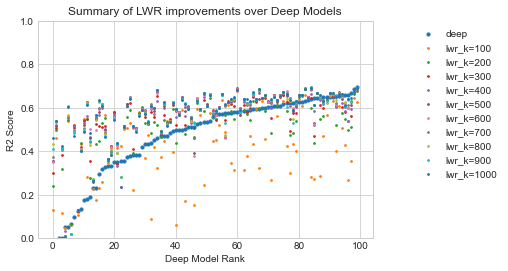

In [12]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

In [13]:
scores_df["n_features"] = [deep_models[i].n_features for i in scores_df["model_num"]] 

In [14]:
from matplotlib.colors import Colormap
import seaborn as sns #heatmap of features - pls model - score
class nlcmap(Colormap):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)
    
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)


In [15]:
subset = scores_df[["predictor","n_features","R2"]]
subset = subset[np.logical_not(subset["predictor"]=="deep")]
subset = subset[np.logical_not(subset["predictor"]=="lr")]
trans = subset["predictor"].transform(lambda x: int(x.replace("lwr_k=",""))).tolist()
subset.loc[:,"predictor"]=trans
subset=subset.sort_values("predictor",ascending=False)

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

C:\Users\huonf\AppData\Local\Temp\ipykernel_100516\3702862414.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sc,label="R2 Score")


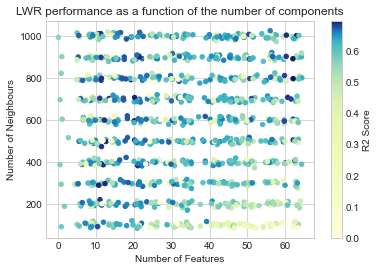

In [16]:
fig, ax = plt.subplots()
sc = ax.scatter(x=rand_jitter(subset["n_features"]), y=rand_jitter(subset["predictor"]), s=20,c=subset["R2"],cmap=cmap_nonlin,vmin=0)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Number of Neighbours")

cbar = fig.colorbar(sc,label="R2 Score")

ax.set_title("LWR performance as a function of the number of components")
plt.savefig(log_dir/f"heat_scatter.png", bbox_inches='tight')